# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Ching Hu - Project 1: finding lines

### Process image function

In [397]:
def process_image(image):
    imgYUV = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel to enhance contrast
    imgYUV[:,:,0] = cv2.equalizeHist(imgYUV[:,:,0])

    # convert the YUV image back to RGB format
    imgEqualized = cv2.cvtColor(imgYUV, cv2.COLOR_YUV2BGR)


    #printing out some stats and plotting
    #print('This image is:', type(image), 'with dimensions:', image.shape)
    #plt.imshow(imgEqualized)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

    # ============ Convert to grayscale
    imgGray = cv2.cvtColor(imgEqualized, cv2.COLOR_BGR2GRAY)

    # ============ Apply Gaussian blur
    blurKernalSize = 5
    imgBlur = cv2.GaussianBlur(imgGray, (blurKernalSize, blurKernalSize), 0)

    # ============ Adaptive threshold (I tried Canny as well, liked the adaptive version more)
    thresholdBlockSize = 7
    thresholdParam = 5 # lower the number, more noise, max number of 5 gives cleanest image, this is the weighted mean
    imgThreshold = cv2.adaptiveThreshold(imgBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,thresholdBlockSize,thresholdParam)
    #imgThreshold = cv2.Canny(imgBlur, 50, 150)  # does not produce better result than adaptive threshold
    #plt.imshow(imgThreshold, cmap='gray')

    # ============ Select region of interest (ROI)
    def region_of_interest(img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img) 


        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255


        #filling pixels inside the polygon defined by "vertices" with the fill color
        cv2.fillPoly(mask, [vertices], ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    # Pull out the x and y sizes and make a copy of the image
    ysize = imgThreshold.shape[0]
    xsize = imgThreshold.shape[1]
    imgROI = np.copy(imgThreshold)

    # Define our color criteria
    red_threshold = 0
    green_threshold = 0
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Define a triangle region of interest 
    triangle_y1 = ysize
    triangle_x1 = xsize/8
    triangle_y2 = ysize
    triangle_x2 = xsize *14/15
    triangle_apex_y = ysize/1.72
    triangle_apex_x = xsize/2
    triangle = np.array([[triangle_x1, triangle_y1], \
                         [triangle_x2, triangle_y2], \
                         [triangle_apex_x, triangle_apex_y]], \
                        np.int32)

    imgROI = region_of_interest(imgROI, triangle)
    plt.imshow(imgROI, cmap='gray')

    # ============ Draw the Hough lines based on masedk threshold image
    def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        # Global variable to store the information of previous frame 
        # for single frame image, this needs to be reset after each image
        # for video, reset at the end of each video
        global previousFrame
        
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

        #use averaging method to calculate the continuous line based on the probabilistic Hough Lines
        leftLine = [] # used to store all detected left lane segments
        rightLine = [] # used to store all detected rigth lane segments

        #first run through all the Hough Lines, and group them into left or right based on the sign of their slope
        for line in lines:
            for x1,y1,x2,y2 in line:
                # based on y = mx + b, where m = slope, b = intercept
                m = (y2 - y1) / (x2 - x1) 
                b = y1 - m*x1 
                length = math.sqrt((y2 - y1)**2.0 + (x2 - x1)**2.0)

                # emperically determine what are the reasonable angles and what are not reasonable
                # this will constrain the detection to further reduce noisy lines
                # these bounds work well on the test images (0.55 < m < 1.0) or (-1.0 < m < -0.55)
                if (0.55 < m < 1.0) or (-1.0 < m < -0.55):
                    if m > 0 :
                            leftLine.append((m, b, length))
                    elif m < 0:
                            rightLine.append((m, b, length))
                else:
                    pass


        # average m and b based on all m and b collected, 
        # and longer length (i.e. less likely to be noise) should have stronger influence on the overall average
        leftLine = np.array(leftLine)
        leftLine_m = np.average(leftLine[:, 0], weights=leftLine[:, 2])
        leftLine_b = np.average(leftLine[:, 1], weights=leftLine[:, 2])

        rightLine = np.array(rightLine)        
        rightLine_m = np.average(rightLine[:, 0], weights=rightLine[:, 2])
        rightLine_b = np.average(rightLine[:, 1], weights=rightLine[:, 2])

        # address the annoying jittering of detected lines from frame to frame
        weight = 0.5 # just keep it evenly weighted 
        if not previousFrame:
            pass
        else:
            previousLeftLine_m = weight*previousFrame[0][0]
            previousLeftLine_b = weight*previousFrame[0][1]
            previousRightLine_m = weight*previousFrame[1][0]
            previousRightLine_b = weight*previousFrame[1][1]
            leftLine_m = previousLeftLine_m + (1. - weight)*leftLine_m
            leftLine_b = previousLeftLine_b + (1. - weight)*leftLine_b
            rightLine_m = previousRightLine_m + (1. - weight)*rightLine_m
            rightLine_b = previousRightLine_b + (1. - weight)*rightLine_b
            
        previousFrame = tuple(((leftLine_m, leftLine_b), (rightLine_m, rightLine_b)))
    
        # draw line within the defined triangle region of interest
        leftLine_y1 = int(triangle_y1)
        leftLine_x1 = int((leftLine_y1 - leftLine_b) / leftLine_m)
        
        leftLine_y2 = int(triangle_apex_y)
        leftLine_x2 = int((leftLine_y2 - leftLine_b) / leftLine_m)
        cv2.line(line_img, (leftLine_x1, leftLine_y1), (leftLine_x2, leftLine_y2), color=[0,255,0], thickness=3)


        rightLine_y1 = int(triangle_y2)
        rightLine_x1 = int((rightLine_y1 - rightLine_b) / rightLine_m)

        rightLine_y2 = int(triangle_apex_y)
        rightLine_x2 = int((rightLine_y2 - rightLine_b) / rightLine_m)
        cv2.line(line_img, (rightLine_x1, rightLine_y1), (rightLine_x2, rightLine_y2), color=[0,255,0], thickness=5)

        return line_img

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 6    # maximum gap in pixels between connectable line segments

    imgHoughLines = hough_lines(imgROI, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.imshow(imgHoughLines, cmap='gray')

    def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.

        `initial_img` should be the image before any processing.

        The result image is computed as follows:

        initial_img * α + img * β + λ
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)

    result = weighted_img(imgHoughLines, image)

    return result

### Static image processing

file name = .DS_Store
file name = solidWhiteCurve.jpg
file name = solidWhiteRight.jpg
file name = solidYellowCurve.jpg
file name = solidYellowCurve2.jpg
file name = solidYellowCurve2_objectOnRoad.jpg
file name = solidYellowCurve_darkSquigleLines.jpg
file name = solidYellowLeft.jpg
file name = solidYellowLeft_simFog.jpg
file name = whiteCarLaneSwitch.jpg
file name = whiteCarLaneSwitch_lightStrip.jpg


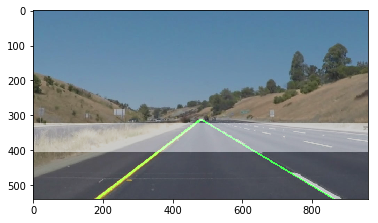

In [406]:
#importing some useful packages
import sys

#for OpenCV to work on my Mac OS X, I need to insert this path here
sys.path.insert(1, '/Users/ching/miniconda2/pkgs/opencv3-3.1.0-py35_0/lib/python3.5/site-packages')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline


# ============ process images in input folder
inputFolderPath = 'test_images/'
outputFolderPath = 'ching_test_images_output/'
inputImageFilename = 'whiteCarLaneSwitch_lightStrip'
image = mpimg.imread(inputFolderPath + inputImageFilename + '.jpg')

for inputImageFilename in os.listdir(inputFolderPath):
        path = inputFolderPath + inputImageFilename
        print ("file name = " + inputImageFilename)
        inputImageFileNameOnly, fileExtension = inputImageFilename.split(".")
        
        # make sure to process a few image types, and not any other file types
        if fileExtension in ('jpg', 'png', 'bmp', 'tiff'):
            outputImageFileName = outputFolderPath + inputImageFileNameOnly + "_overlay." + fileExtension
            image = mpimg.imread(inputFolderPath + inputImageFilename)
            result = process_image(image)
       
            # ============ remember to reset the previous frame in case we are doing multiple frames in video
            previousFrame = []
            imgOverlay = process_image(image)
            cv2.imwrite(outputImageFileName, cv2.cvtColor(imgOverlay, cv2.COLOR_RGB2BGR))
            plt.imshow(imgOverlay, cmap='gray')
        else:
            pass



## Video processing

In [293]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video ching_test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video ching_test_videos_output/solidWhiteRight.mp4




















  0%|          | 0/222 [00:00<?, ?it/s]

















  2%|▏         | 4/222 [00:00<00:05, 38.50it/s]

















  4%|▍         | 9/222 [00:00<00:05, 40.53it/s]

















  6%|▋         | 14/222 [00:00<00:05, 40.55it/s]

















  9%|▊         | 19/222 [00:00<00:04, 41.07it/s]

















 11%|█         | 24/222 [00:00<00:04, 41.21it/s]

















 13%|█▎        | 29/222 [00:00<00:04, 41.27it/s]

















 15%|█▌        | 34/222 [00:00<00:04, 41.67it/s]

















 18%|█▊        | 39/222 [00:00<00:04, 41.61it/s]

















 20%|█▉        | 44/222 [00:01<00:04, 42.08it/s]

















 22%|██▏       | 49/222 [00:01<00:04, 36.68it/s]

















 24%|██▍       | 53/222 [00:01<00:04, 34.64it/s]

















 26%|██▌       | 57/222 [00:01<00:04, 34.63it/s]

















 27%|██▋       | 61/222 [00:01<00:04, 33.57it/s]

















 29%|██▉       | 65/222 [00:01<00:04, 33.01it/s]

















 31

[MoviePy] Done.
[MoviePy] >>>> Video ready: ching_test_videos_output/solidWhiteRight.mp4 



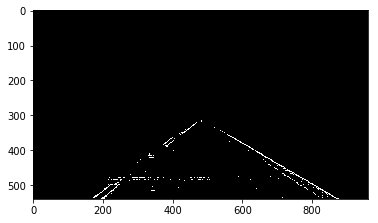

In [407]:
# white right lane
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!

white_output = 'ching_test_videos_output/solidWhiteRight.mp4'
white_clip.write_videofile(white_output, audio=False)

#%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



















  0%|          | 0/682 [00:00<?, ?it/s]
















  1%|          | 4/682 [00:00<00:19, 34.48it/s]
















  1%|▏         | 9/682 [00:00<00:17, 37.51it/s]
















  2%|▏         | 14/682 [00:00<00:16, 39.50it/s]
















  3%|▎         | 19/682 [00:00<00:16, 40.35it/s]
















  4%|▎         | 24/682 [00:00<00:15, 41.57it/s]
















  4%|▍         | 29/682 [00:00<00:15, 41.87it/s]
















  5%|▍         | 34/682 [00:00<00:15, 42.25it/s]
















  6%|▌         | 39/682 [00:00<00:15, 41.22it/s]
















  6%|▋         | 44/682 [00:01<00:15, 41.13it/s]
















  7%|▋         | 48/682 [00:01<00:18, 34.90it/s]
















  8%|▊         | 52/682 [00:01<00:18, 33.73it/s]
















  8%|▊         | 56/682 [00:01<00:19, 32.08it/s]
















  9%|▉         | 60/682 [00:01<00:19, 31.80it/s]
















  9%|▉         | 64/682 [00:01<00:20, 30.76it/s]
















 10%|▉         | 68

 38%|███▊      | 257/682 [00:09<00:18, 22.49it/s]
















 38%|███▊      | 260/682 [00:09<00:18, 23.39it/s]
















 39%|███▊      | 263/682 [00:09<00:17, 23.41it/s]
















 39%|███▉      | 266/682 [00:09<00:17, 24.03it/s]
















 39%|███▉      | 269/682 [00:09<00:17, 23.65it/s]
















 40%|███▉      | 272/682 [00:10<00:16, 24.66it/s]
















 40%|████      | 275/682 [00:10<00:16, 25.17it/s]
















 41%|████      | 278/682 [00:10<00:15, 25.37it/s]
















 41%|████      | 281/682 [00:10<00:15, 26.17it/s]
















 42%|████▏     | 284/682 [00:10<00:14, 26.69it/s]
















 42%|████▏     | 287/682 [00:10<00:15, 26.14it/s]
















 43%|████▎     | 290/682 [00:10<00:16, 24.37it/s]
















 43%|████▎     | 293/682 [00:10<00:17, 22.56it/s]
















 43%|████▎     | 296/682 [00:10<00:15, 24.14it/s]
















 44%|████▍     | 299/682 [00:11<00:15, 25.23it/s]
















 44%|████▍

 69%|██████▊   | 468/682 [00:17<00:08, 24.14it/s]
















 69%|██████▉   | 471/682 [00:17<00:08, 23.99it/s]
















 70%|██████▉   | 474/682 [00:17<00:08, 24.55it/s]
















 70%|██████▉   | 477/682 [00:17<00:08, 24.81it/s]
















 70%|███████   | 480/682 [00:18<00:08, 25.07it/s]
















 71%|███████   | 483/682 [00:18<00:07, 25.22it/s]
















 71%|███████▏  | 486/682 [00:18<00:07, 25.70it/s]
















 72%|███████▏  | 489/682 [00:18<00:07, 25.33it/s]
















 72%|███████▏  | 492/682 [00:18<00:07, 25.18it/s]
















 73%|███████▎  | 495/682 [00:18<00:07, 24.84it/s]
















 73%|███████▎  | 498/682 [00:18<00:07, 24.66it/s]
















 73%|███████▎  | 501/682 [00:18<00:07, 25.09it/s]
















 74%|███████▍  | 504/682 [00:19<00:06, 25.67it/s]
















 74%|███████▍  | 507/682 [00:19<00:06, 25.18it/s]
















 75%|███████▍  | 510/682 [00:19<00:06, 25.21it/s]
















 75%|█████

 99%|█████████▉| 678/682 [00:26<00:00, 24.33it/s]
















100%|█████████▉| 681/682 [00:26<00:00, 24.01it/s]


















[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 



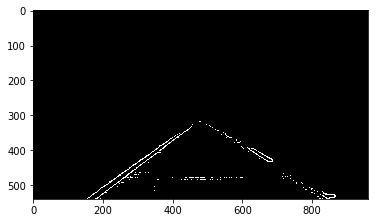

In [392]:
# yellow curve line on left
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")

yellow_clip = clip2.fl_image(process_image)  # NOTE: this function expects color images!!

yellow_output = 'ching_test_videos_output/solidYellowLeft.mp4'
yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4




















  0%|          | 0/251 [00:00<?, ?it/s]

















  1%|          | 2/251 [00:00<00:12, 19.28it/s]

















  2%|▏         | 5/251 [00:00<00:12, 19.88it/s]

















  3%|▎         | 8/251 [00:00<00:11, 20.54it/s]

















  4%|▍         | 11/251 [00:00<00:11, 20.84it/s]

















  5%|▌         | 13/251 [00:00<00:11, 19.98it/s]

















  6%|▌         | 15/251 [00:00<00:11, 19.68it/s]

















  7%|▋         | 18/251 [00:00<00:11, 19.92it/s]

















  8%|▊         | 20/251 [00:00<00:11, 19.88it/s]

















  9%|▉         | 23/251 [00:01<00:11, 20.20it/s]

















 10%|▉         | 25/251 [00:01<00:11, 19.33it/s]

















 11%|█         | 27/251 [00:01<00:12, 18.23it/s]

















 12%|█▏        | 29/251 [00:01<00:11, 18.57it/s]

















 13%|█▎        | 32/251 [00:01<00:11, 19.00it/s]

















 14%|█▎        | 34/251 [00:01<00:11, 19.25it/s]

















 14%

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



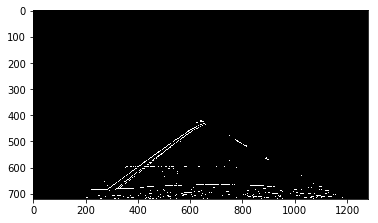

In [399]:
# Challenge video:  this one got me stuck for a while!  the result is still not what I wanted.
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

clip3 = VideoFileClip("test_videos/challenge.mp4")

challenge_clip = clip3.fl_image(process_image)  # NOTE: this function expects color images!!

challenge_output = 'ching_test_videos_output/challenge.mp4'
challenge_clip.write_videofile(challenge_output, audio=False)


## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!